<font size=5, font color=blue> Section 1: Exploratory data analysis

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import callbacks
from tensorflow.keras import Sequential, layers, regularizers
import numpy as np
from scipy.stats import pearsonr, spearmanr
from tensorflow.keras.callbacks import EarlyStopping
import talib
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.losses import Loss
from tensorflow.keras.utils import register_keras_serializable
import tensorflow.keras.backend as K
from hmmlearn.hmm import GaussianHMM

<font size=4, font color=blue> Start with Apple stock data only.

In [4]:
path = os.path.join(".", "Data", "train", "AAPL.csv")

df = pd.read_csv(path)

df.head()

,Dt,Adj Close,Close,Div,Factor,High,Low,Open,Volume
0,2000-01-03,3.4785,111.938,0.0,1.0,112.500,101.688,104.8750,133949200.0
1,2000-01-04,3.1852,102.500,0.0,1.0,110.625,101.188,108.2500,128094400.0
2,2000-01-05,3.2318,104.000,0.0,1.0,110.563,103.000,103.7500,194580400.0
3,2000-01-06,2.9521,95.000,0.0,1.0,107.000,95.000,106.1183,191993200.0
4,2000-01-07,3.0920,99.500,0.0,1.0,101.000,95.500,96.5000,115183600.0


<font size=4, font color=blue> Return is (current day adjusted close - previous day adjusted close)/previous day adjusted close. Target_return column is next day's return, which my models will try to predict using current day's and all previous days' data. By multiplying the predicted return for tomorrow with today's adjusted close price, we can get the predicted adjusted close price for tomorrow. Thus this project is a regression ML task, and MSE is the natural choice for loss. 

<font size=4, font color=blue> I chose to calculate return based on adjusted close price instead of the close price because adjusted close price accounts for the impact of events like stock splits and dividends, which can cause fluctuations in the close price. Adjusted close price is considered more consistent and suitable for long-term analysis. 

In [5]:
df['return']=df['Adj Close'].pct_change()
df['target_return']=df['return'].shift(-1)
df.head()

,Dt,Adj Close,Close,Div,Factor,High,Low,Open,Volume,return,target_return
0,2000-01-03,3.4785,111.938,0.0,1.0,112.500,101.688,104.8750,133949200.0,NaN,-0.084318
1,2000-01-04,3.1852,102.500,0.0,1.0,110.625,101.188,108.2500,128094400.0,-0.084318,0.014630
2,2000-01-05,3.2318,104.000,0.0,1.0,110.563,103.000,103.7500,194580400.0,0.014630,-0.086546
3,2000-01-06,2.9521,95.000,0.0,1.0,107.000,95.000,106.1183,191993200.0,-0.086546,0.047390
4,2000-01-07,3.0920,99.500,0.0,1.0,101.000,95.500,96.5000,115183600.0,0.047390,-0.017594


<font size=4, font color=blue> Notice that the features have very different scales.

In [4]:
df.describe()

,Adj Close,Close,Div,Factor,High,Low,Open,Volume,return,target_return
count,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4.277000e+03,4276.000000,4276.000000
mean,34.065846,170.450354,0.001999,1.001870,172.424040,168.407568,170.528689,1.299660e+08,0.001186,0.001186
std,36.698987,173.484604,0.031011,0.094251,174.989551,171.934671,173.604272,9.970883e+07,0.026760,0.026760
min,0.815400,13.120000,0.000000,1.000000,13.190000,12.720000,12.990000,9.835000e+06,-0.518677,-0.518677
25%,3.115300,39.759000,0.000000,1.000000,40.260000,39.030000,39.530000,6.363350e+07,-0.011262,-0.011262
50%,16.948300,106.745000,0.000000,1.000000,108.360000,105.200000,106.959000,1.016484e+08,0.000806,0.000806
75%,62.413600,222.250000,0.000000,1.000000,224.980000,217.890000,220.010000,1.679636e+08,0.013808,0.013808
max,122.771400,702.100000,0.570000,7.000000,705.070000,699.570000,702.410000,1.855410e+09,0.139042,0.139042


<font size=4, font color=blue> No missing data in the original dataset. Return and target_return columns have one null value at the beginning and at the end respectively.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Dt             4277 non-null   object 
 1   Adj Close      4277 non-null   float64
 2   Close          4277 non-null   float64
 3   Div            4277 non-null   float64
 4   Factor         4277 non-null   float64
 5   High           4277 non-null   float64
 6   Low            4277 non-null   float64
 7   Open           4277 non-null   float64
 8   Volume         4277 non-null   float64
 9   return         4276 non-null   float64
 10  target_return  4276 non-null   float64
dtypes: float64(10), object(1)
memory usage: 367.7+ KB


<font size=4, font color=blue> Apple stock prices started to rise quickly from around 2009, with two big drawdowns in 2013 and 2016. Almost all daily returns are within -10% to 10%.

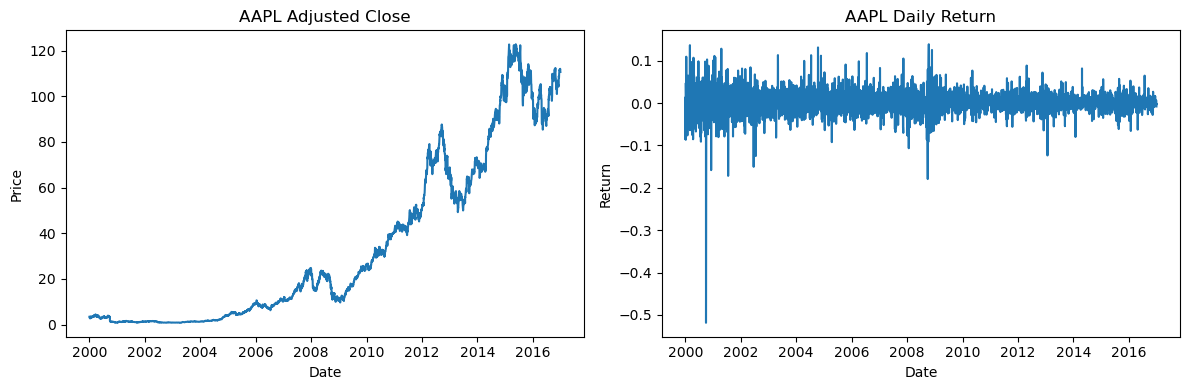

In [6]:
df['Dt'] = pd.to_datetime(df['Dt'])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

axes[0].plot(df['Dt'], df['Adj Close'])
axes[0].set_title('AAPL Adjusted Close')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Price')

axes[1].plot(df['Dt'], df['return'])
axes[1].set_title('AAPL Daily Return')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Return')

fig.tight_layout()
plt.show()

<font size=4, font color='blue'> Regime Change Detection (GaussianHMM)

In [11]:
df1 = df.copy()

scaler = StandardScaler()
df1['10D_Vol'] = df1['return'].rolling(window=10).std()
df1.dropna(inplace=True)
features = df1[['return', 'Volume','10D_Vol']]
features_scaled = scaler.fit_transform(features)

model = GaussianHMM(n_components=3, covariance_type="full", n_iter=1000, random_state=42)
model.fit(features_scaled)

hidden_states = model.predict(features_scaled)
df1['Regime'] = hidden_states
df1.head()

,Dt,Adj Close,Close,Div,Factor,High,Low,Open,Volume,return,target_return,10D_Vol,Regime
10,2000-01-18,3.2299,103.938,0.0,1.0,106.00,100.4380,101.000,114794400.0,0.034860,0.025233,0.064954,2
11,2000-01-19,3.3114,106.563,0.0,1.0,108.75,103.3750,105.625,149410800.0,0.025233,0.065108,0.059163,2
12,2000-01-20,3.5270,113.500,0.0,1.0,121.50,113.5000,115.500,457783200.0,0.065108,-0.019280,0.062112,2
13,2000-01-21,3.4590,111.313,0.0,1.0,114.25,110.1880,114.250,123981200.0,-0.019280,-0.045476,0.053474,2
14,2000-01-24,3.3017,106.250,0.0,1.0,112.75,105.1315,108.438,110219200.0,-0.045476,0.056486,0.055675,2


In [13]:
df1['Regime'].to_list()

[2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,


<font size=5, font color=blue> Section 2: Model Developing and Feature Engineering

<font size=4, font color=blue> The following function takes a MLP(multi-layered fully-connected neural network) model as an argument and trains it on another argument -- dataframe 'df' containing stock features and target_return as the target variable. Each input sample is 1D, in other words just one row of feature values (one day's data) in df.

In [14]:
def train_regression_model(model,
                           df,
                           target_col='target_return',
                           test_size=0.2,
                           batch_size=32,
                           epochs=100,
                           patience=10,
                           scale=True,
                           shuffle=False):
   
    feature_cols = [c for c in df.columns if (c != target_col and c!='Dt') ]
    X = df[feature_cols].values
    y = df[target_col].values
    
    if scale==True:
        X_scaled = _expanding_scale(X)
    else:
        X_scaled = X
    X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(
        X_scaled, y, test_size=test_size, shuffle=shuffle
    )

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    es = callbacks.EarlyStopping(monitor='val_loss',
                                 patience=patience,
                                 restore_best_weights=True)

    history = model.fit(
        X_train_scaled[1:], y_train[1:],
        validation_data=(X_val_scaled, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[es],
        verbose=1
    )

    plt.plot(history.history['loss'],  label='train MSE')
    plt.plot(history.history['val_loss'],label='val   MSE')
    plt.legend()
    plt.title('Training & Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.show()

    return model, history


<font size=4, font color=blue> First, train a baseline model using only the original features in the df above (open, high, low, close, adj close, volume) as predictors, and target_return as the target. Loss (MSE) is very big and this model clearly doesn't learn very well.

Epoch 1/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 235063123902464.0000 - mae: 9648680.0000 - val_loss: 120883781632.0000 - val_mae: 307612.4688
Epoch 2/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 22887266254848.0000 - mae: 3098458.2500 - val_loss: 93645946880.0000 - val_mae: 270752.1875
Epoch 3/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 11846851493888.0000 - mae: 1645247.3750 - val_loss: 2391043328.0000 - val_mae: 43263.2344
Epoch 4/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2669375127552.0000 - mae: 1035486.4375 - val_loss: 1423968000.0000 - val_mae: 33386.8750
Epoch 5/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1800501329920.0000 - mae: 817008.2500 - val_loss: 4030676992.0000 - val_mae: 56171.5742
Epoch 6/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1118615896064.0000 - mae: 572507.5625 - val_loss: 660682048.0000 - val_mae: 22741.6562
Epoch 7/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 751699755008.0000 - mae: 424611.

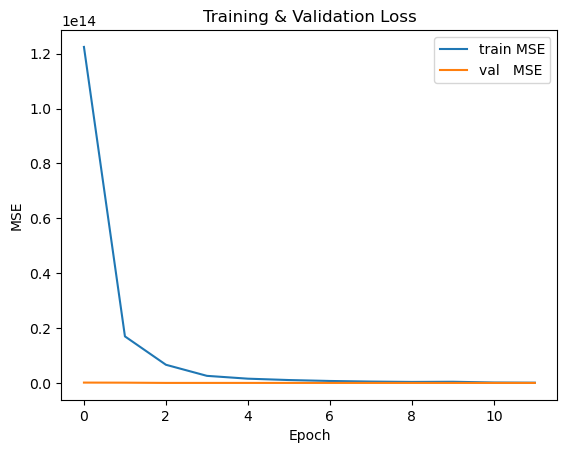

In [28]:
baseline_model = Sequential([
    layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu',kernel_regularizer=regularizers.l2(1e-4)),  
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu',kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.2),
    layers.Dense(1, activation='linear')
])

trained_baseline_model, base_history = train_regression_model(
    model=baseline_model,
    df=df.dropna(),
    target_col='target_return',
    test_size=0.2,
    batch_size=32,
    epochs=100,
    patience=5,
    scale=False,
    shuffle=False
)

<font size=4, font color=blue> As I mentioned above, features are on different scales. However, the normal standardization method in which the whole training set is standardized together cannot be applied here because it will introduce look-ahead bias as future dates' information will be combined into current day's feature values. Here, we define _expanding_scale function, in which all features of a certain date are only standardized with feature values of dates before it, similar to the concept of an expanding window.

In [7]:
def _expanding_scale(X):
    """
    Expanding-window scaling: each row i is scaled by fitting on rows [0:i].
    The first row is left as-is (no scaling).
    """
    scaler = StandardScaler()
    X = np.array(X, dtype=float)
    X_scaled = np.zeros_like(X)
    for i in range(len(X)):
        if i == 0:
            X_scaled[i] = X[i]
        else:
            scaler.fit(X[:i+1])
            X_scaled[i] = scaler.transform(X[i:i+1])[0]
    return X_scaled

<font size=4, font color=blue> Some new features can be engineered from the original features (open, close, high, low, adj close, volume) through relatively simple operations like subtraction (e.g. open-close difference), division (e.g. close-open ratio) and rolling-window mean (e.g. 5-day mean return). I won't describe all of them here because only some of them are used in the final model (the ones used will be described in the sub-section containing the final model). These new features are commonly used in stock analysis as a way to explore the interaction between the original features and to reflect/summarize recent trends of the stock price movements. They are a rudimentary form of 'convolution' across the non-feature dimension: time.

In [8]:
df['oc_return'] = (df['Close'] - df['Open']) / df['Open']
df['hl_pct'] = (df['High'] - df['Low']) / df['Close']
df['ch_gap'] = df['Close'] - df['High']
df['cl_gap'] = df['Close'] - df['Low']
df['co_ratio'] = df['Close'] / df['Open']
df['oc_diff'] = df['Close'] - df['Open']
df['prev_return'] = df['return'].shift(1)
df['rolling_mean_5'] = df['Adj Close'].rolling(5).mean()
df['rolling_std_5'] = df['Adj Close'].rolling(5).std()
df['rolling_mean_20'] = df['Adj Close'].rolling(20).mean()
df['rolling_std_20'] = df['Adj Close'].rolling(20).std()
df['zscore_20'] = (df['Adj Close'] - df['rolling_mean_20']) / df['rolling_std_20']
df['volume_chg'] = df['Volume'].pct_change()
df['volume_zscore'] = (df['Volume'] - df['Volume'].rolling(20).mean()) / df['Volume'].rolling(20).std()
df['vol_to_range'] = df['Volume'] / (df['High'] - df['Low'])
df['price_range'] = df['High'] - df['Low']
df['overnight_gap'] = df['Open'] / df['Close'].shift(1) - 1
df['rolling_max_10'] = df['High'].rolling(10).max()
df['rolling_min_10'] = df['Low'].rolling(10).min()
df['range_ratio'] = df['rolling_max_10'] / df['rolling_min_10']

df_cleaned = df.dropna(inplace=False)
df_cleaned.head()

,Dt,Adj Close,Close,Div,Factor,High,Low,Open,Volume,return,...,rolling_std_20,zscore_20,volume_chg,volume_zscore,vol_to_range,price_range,overnight_gap,rolling_max_10,rolling_min_10,range_ratio
19,2000-01-31,3.2240,103.750,0.0,1.0,103.875,94.4979,101.000,175420000.0,0.020899,...,0.222632,0.054350,0.657451,0.215866,1.870728e+07,9.3771,-0.006150,121.500,94.4979,1.285743
20,2000-02-01,3.1153,100.250,0.0,1.0,105.000,100.0000,104.000,79508800.0,-0.033716,...,0.214402,-0.365855,-0.546752,-0.856461,1.590176e+07,5.0000,0.002410,121.500,94.4979,1.285743
21,2000-02-02,3.0706,98.813,0.0,1.0,102.125,97.0000,100.750,116048800.0,-0.014349,...,0.216166,-0.543146,0.459572,-0.429525,2.264367e+07,5.1250,0.004988,121.500,94.4979,1.285743
22,2000-02-03,3.2104,103.313,0.0,1.0,104.250,100.2500,100.313,118798400.0,0.045529,...,0.215991,0.108616,0.023693,-0.355686,2.969960e+07,4.0000,0.015180,114.250,94.4979,1.209022
23,2000-02-04,3.3561,108.000,0.0,1.0,110.000,103.6250,103.938,106330000.0,0.045384,...,0.211722,0.703565,-0.104954,-0.449911,1.667922e+07,6.3750,0.006050,114.188,94.4979,1.208365


In [9]:
simple_features = [
    'oc_return', 'hl_pct', 'ch_gap', 'cl_gap', 'co_ratio', 'oc_diff', 'prev_return',
    'rolling_mean_5', 'rolling_std_5', 'rolling_mean_20', 'rolling_std_20', 'zscore_20',
    'volume_chg', 'volume_zscore', 'vol_to_range', 'price_range', 'overnight_gap',
    'rolling_max_10', 'rolling_min_10', 'range_ratio'
]

<font size=4, font color=blue> We need to do feature selection here. An intuitive way to check whether a feature is good or not is to compute the correlation between current day's feature value and next day's return. A high correlation (either positive or negative) will make it easier to predict target_return accurately when we have today's feature value. Apart from the correlation, which is static, we can also compute the information ratio of the feature as (mean of 252-day rolling-window correlations between feature and target_return)/std of 252-day rolling-window correlations. The larger the absolute value of the information ratio, the more stable and significant the feature is.

<font size=4, font color=blue> Pearson's correlation r measures the strength and direction of the linear relationship between feature and target_return. Spearman's rank correlation rho measures the strength and direction of the relationship between two variables when the relationship is monotonic (meaning it's either consistently increasing or decreasing), but not necessarily linear.

In [10]:
def compute_ic_ir(df, features, window=252, min_periods=50):
    """
    window: rolling window length for IR (e.g. 252 trading days)
    min_periods: min obs in window to start computing rolling corr
    """
    results = []
    
    for col in features:
        tmp = df[[col, 'target_return']].dropna()
        
        # Instant IC metrics
        pearson_r, _   = pearsonr(tmp[col], tmp['target_return'])
        spearman_rho, _ = spearmanr(tmp[col], tmp['target_return'])
        
        # Rolling Pearson IC series
        rolling_pearson = tmp[col].rolling(window, min_periods=min_periods).corr(tmp['target_return'])
        ir_pearson = rolling_pearson.mean() / rolling_pearson.std()
        
        # Rolling Spearman IC via ranks
        ranks_col    = tmp[col].rank()
        ranks_target = tmp['target_return'].rank()
        rolling_spearman = ranks_col.rolling(window, min_periods=min_periods).corr(ranks_target)
        ir_spearman = rolling_spearman.mean() / rolling_spearman.std()
        
        results.append({
            'feature':        col,
            'Pearson r':      pearson_r,
            'Spearman ρ':     spearman_rho,
            'IR (Pearson)':   ir_pearson,
            'IR (Spearman)':  ir_spearman
        })
    
    return pd.DataFrame(results).set_index('feature').round(4)

scores_simple = compute_ic_ir(df_cleaned, simple_features)
scores_simple

,Pearson r,Spearman ρ,IR (Pearson),IR (Spearman)
feature,,,,
oc_return,-0.0639,-0.0462,-0.6297,-0.4984
hl_pct,0.0078,-0.0102,0.4477,0.2749
ch_gap,-0.0251,-0.0248,-0.9382,-0.3443
cl_gap,-0.0356,-0.0343,-0.7935,-0.8222
co_ratio,-0.0639,-0.0462,-0.6297,-0.4984
oc_diff,-0.0247,-0.0196,-0.6358,-0.3730
prev_return,-0.0159,-0.0289,-0.2872,-0.4781
rolling_mean_5,-0.0162,-0.0034,-1.4445,-1.4399
rolling_std_5,0.0026,0.0055,0.1324,0.0716


<font size=4, font color=blue> The threshold here is: new feature must satisfy either one of (1) abs(pearson r)>0.02 and IR(pearson r)>0.5 (2) abs(spearman rho)>0.02 and IR(spearman rho)>0.5. Eight new features passed the test. Their description will be included in a later section.

In [11]:
mask = (
    (scores_simple['Pearson r'].abs() > 0.02) & 
    (scores_simple['IR (Pearson)'].abs() > 0.5)
) | (
    (scores_simple['Spearman ρ'].abs() > 0.02) & 
    (scores_simple['IR (Spearman)'].abs() > 0.5)
)

selected_features = scores_simple[mask]

chosen_simple = selected_features.index.to_list()
chosen_simple

['oc_return',
 'ch_gap',
 'cl_gap',
 'co_ratio',
 'oc_diff',
 'volume_zscore',
 'vol_to_range',
 'overnight_gap']

<font size=4, font color=blue> The other new features are dropped.

In [12]:
to_drop = [f for f in simple_features if f not in chosen_simple]

df_cleaned = df_cleaned.drop(columns=to_drop)
df_cleaned.drop(columns=['Div','Factor'],inplace=True)
df_cleaned.head()

,Dt,Adj Close,Close,High,Low,Open,Volume,return,target_return,oc_return,ch_gap,cl_gap,co_ratio,oc_diff,volume_zscore,vol_to_range,overnight_gap
19,2000-01-31,3.2240,103.750,103.875,94.4979,101.000,175420000.0,0.020899,-0.033716,0.027228,-0.125,9.2521,1.027228,2.750,0.215866,1.870728e+07,-0.006150
20,2000-02-01,3.1153,100.250,105.000,100.0000,104.000,79508800.0,-0.033716,-0.014349,-0.036058,-4.750,0.2500,0.963942,-3.750,-0.856461,1.590176e+07,0.002410
21,2000-02-02,3.0706,98.813,102.125,97.0000,100.750,116048800.0,-0.014349,0.045529,-0.019226,-3.312,1.8130,0.980774,-1.937,-0.429525,2.264367e+07,0.004988
22,2000-02-03,3.2104,103.313,104.250,100.2500,100.313,118798400.0,0.045529,0.045384,0.029906,-0.937,3.0630,1.029906,3.000,-0.355686,2.969960e+07,0.015180
23,2000-02-04,3.3561,108.000,110.000,103.6250,103.938,106330000.0,0.045384,0.056137,0.039081,-2.000,4.3750,1.039081,4.062,-0.449911,1.667922e+07,0.006050


In [13]:
df.drop(columns=to_drop,inplace=True)

<font size=4, font color=blue> Both training and validation set losses become much smaller now using the new features and expanding standardization method. Please note that I used dropout layers in the model, which reduces overfitting but increases training loss.

Epoch 1/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 0.1309 - mae: 0.1793 - val_loss: 0.0264 - val_mae: 0.0148
Epoch 2/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0293 - mae: 0.0429 - val_loss: 0.0247 - val_mae: 0.0116
Epoch 3/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0260 - mae: 0.0319 - val_loss: 0.0232 - val_mae: 0.0129
Epoch 4/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0239 - mae: 0.0268 - val_loss: 0.0218 - val_mae: 0.0114
Epoch 5/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0223 - mae: 0.0229 - val_loss: 0.0204 - val_mae: 0.0110
Epoch 6/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0209 - mae: 0.0215 - val_loss: 0.0192 - val_mae: 0.0108
Epoch 7/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0197 - mae: 0.0205 - val_loss: 0.0180 - val_mae: 0.0109
Epoch 8/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0184 - mae: 0.0201 - val_loss: 0.0170 - val_mae: 0.0108
Epoch 9/100
107/107 ━━━━━━━━━━━━━━━━━━━━

Epoch 54/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0012 - mae: 0.0196 - val_loss: 6.3248e-04 - val_mae: 0.0108
Epoch 55/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0012 - mae: 0.0197 - val_loss: 5.9212e-04 - val_mae: 0.0110
Epoch 56/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0011 - mae: 0.0197 - val_loss: 5.4654e-04 - val_mae: 0.0108
Epoch 57/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0012 - mae: 0.0199 - val_loss: 5.2155e-04 - val_mae: 0.0113
Epoch 58/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0011 - mae: 0.0197 - val_loss: 4.7480e-04 - val_mae: 0.0108
Epoch 59/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0014 - mae: 0.0202 - val_loss: 4.4439e-04 - val_mae: 0.0108
Epoch 60/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.8891e-04 - mae: 0.0198 - val_loss: 4.2381e-04 - val_mae: 0.0111
Epoch 61/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0012 - mae: 0.0196 - val_loss: 3.9658e-04 - val_mae: 0.0109

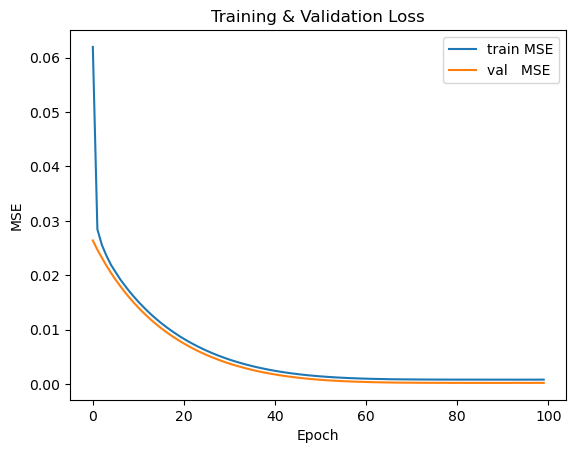

In [15]:
simple_model = Sequential([
    layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(1e-4)), 
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.2),
    layers.Dense(1, activation='linear')
])

trained_simple_model, history = train_regression_model(
    model=simple_model,
    df=df_cleaned,
    target_col='target_return',
    test_size=0.2,
    batch_size=32,
    epochs=100,
    patience=10,
    scale=True,
    shuffle=False
)

<font size=4, font color=blue> Error analysis: Multiply the predicted returns by the corresponding day's adjusted close price to calculate tomorrow's predicted adjusted close price. Do this for all dates in the training set. Calculate and plot the percentage error between each day's true adjusted close price and predicted adjusted close price. It can be seen that errors are relatively stable over time.

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


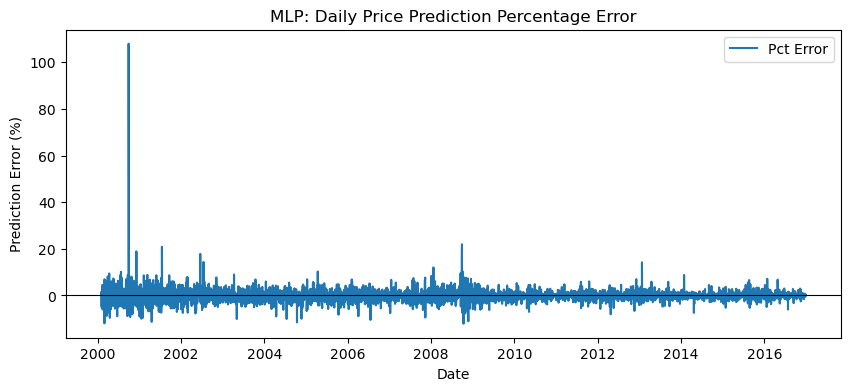

In [159]:
def plot_mlp_train_errors(model, df, price_col='Adj Close', target_col='target_return'):
    
    feature_cols = [c for c in df.columns if c not in (target_col, 'Dt')]
    X_raw = df[feature_cols].values
    
    X_scaled = _expanding_scale(X_raw)[1:]
    
    y_pred = model.predict(X_scaled).flatten()
    
    actual_prices = df[price_col][1:].values
    N = len(actual_prices)
    pred_prices = np.zeros(N)
    pred_prices[0] = actual_prices[0]
    for t in range(1, N):
        pred_prices[t] = actual_prices[t-1] * (1 + y_pred[t-1])
   
    pct_error = (pred_prices - actual_prices) / actual_prices * 100.0
    
    dates = pd.to_datetime(df['Dt'])
    plt.figure(figsize=(10, 4))
    plt.plot(dates[1:], pct_error, label='Pct Error')
    plt.axhline(0, color='black', lw=0.8)
    plt.xlabel('Date')
    plt.ylabel('Prediction Error (%)')
    plt.title('MLP: Daily Price Prediction Percentage Error')
    plt.legend()
    plt.show()


plot_mlp_train_errors(trained_simple_model, df_cleaned)


In [17]:
def return_predictions_mlp(model, df, target_col='target_return'):
    
    
    feature_cols = [c for c in df.columns if c not in ('Dt', target_col)]
    
    X = df[feature_cols].values
    
    y_pred = model.predict(X, verbose=0).flatten()
    
    return y_pred


<font size=4, font color=blue> Everything seems to be going well. However, if we print out the predicted returns, a big problem surfaces: the model is just predicting the mean return for all samples.

In [18]:
return_predictions_mlp(trained_simple_model, df_cleaned, target_col='target_return')[:50]

array([0.00020605, 0.00020605, 0.00020605, 0.00020605, 0.00020605,
       0.00020605, 0.00020605, 0.00020605, 0.00020605, 0.00020605,
       0.00020605, 0.00020605, 0.00020605, 0.00020605, 0.00020605,
       0.00020605, 0.00020605, 0.00020605, 0.00020605, 0.00020605,
       0.00020605, 0.00020605, 0.00020605, 0.00020605, 0.00020605,
       0.00020605, 0.00020605, 0.00020605, 0.00020605, 0.00020605,
       0.00020605, 0.00020605, 0.00020605, 0.00020605, 0.00020605,
       0.00020605, 0.00020605, 0.00020605, 0.00020605, 0.00020605,
       0.00020605, 0.00020605, 0.00020605, 0.00020605, 0.00020605,
       0.00020605, 0.00020605, 0.00020605, 0.00020605, 0.00020605],
      dtype=float32)

<font size=4, font color=blue> A typical problem with using MSE as loss is that the model may 'learn' to predict the average return for all samples/dates to minimize loss. In order to steer the model away from that habit, we can use a custom loss function here, which besides including the MSE in the loss function, also penalizes wrong directional forecast (positive vs negative return) via adding binary cross entropy to the loss function. So an element of classification is added to the regression problem. The weight of the cross entropy loss is alpha.

<font size=4, font color=blue> The logic is that predicting the correct up/down direction is also important. For example, if a stock is predicted to rise but actually falls, then long position loses money, but if it is predicted to rise a lot but only rises a little, the long position still makes a profit. 

In [19]:
def multitask_loss(alpha=1.0):
    """
    Multi-task regression+directional loss:
      L = MSE(y_true, y_pred)
        + alpha * BCE(sign(y_true), sigmoid(y_pred))
    
    - MSE term trains the magnitude of the return.
    - BCE term trains the up/down direction.
    """
    def loss(y_true, y_pred):
        
        mse = K.mean(K.square(y_pred - y_true), axis=-1)
        
        
        y_true_sign = K.cast(K.greater(y_true, 0), K.floatx())
        
        y_pred_prob = K.sigmoid(y_pred)
        
        bce = K.mean(
            K.binary_crossentropy(y_true_sign, y_pred_prob),
            axis=-1
        )
        
      
        return mse + alpha * bce

    return loss


<font size=4, font color=blue> From now on, I use LSTM/Convolutional Neural Networks instead of simple MLPs as the former can better learn temporal patterns and remember long-term time dependencies in the time series data. I now have more information to predict next day's return. This changes the shape of the input (aka example) to the model: instead of each sample being one row of data, it is now a sequence of many consecutive days' feature values, in other words a 2D array with shape (number of lookback periods, number of features). Lookback periods is the number of previous days whose features are used to train the model. Due to the nature of some features and expanding standardization, the actual information available is not limited to days in lookback.

<font size=5, font color=red> The shape of each input sample (aka example) is the same for all the convolutional models trained after this point: 2D array of size (number of lookback periods, number of features). Number of lookback periods is usually set to 20 days, and it is a non-feature dimension (time dimension). Number of features is just all features in the df including original features and engineered new features. A description of each of all the features used will be included in the sub-section where I trained the final model.

<font size=4, font color='blue'> The following function takes a df, standardize it and pack it into 2D samples of shape (number of lookback periods, number of features). These samples are then used to train a LSTM/CNN model.

In [23]:
def train_sequence_model_expanding(model,
                                   df,
                                   target_col='target_return',
                                   lookback=90,
                                   test_size=0.2,
                                   batch_size=32,
                                   epochs=100,
                                   patience=10,
                                   alpha=0.6,
                                   shuffle=False):

    
    df2 = df.copy()
    feature_cols = [c for c in df2.columns if (c != target_col and c != 'Dt')]
    X_raw = df2[feature_cols].values
    y = df2[target_col][1:].values

    
    X_scaled = _expanding_scale(X_raw)[1:]

    
    X_seq, y_seq = [], []
    for i in range(lookback-1, len(X_scaled)):
        X_seq.append(X_scaled[i - lookback + 1 : i + 1])
        y_seq.append(y[i])
    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)
    
    if test_size is not None:
        X_train, X_val, y_train, y_val = train_test_split(
            X_seq, y_seq, test_size=test_size, shuffle=shuffle
        )
        val_data = (X_val, y_val)
        monitor_metric = 'val_loss'
    else:
        X_train, y_train = X_seq, y_seq
        val_data = None
        monitor_metric = 'loss'
        
    
    model.compile(optimizer='adam', loss=multitask_loss(alpha=alpha), metrics=["mae"])
    es = EarlyStopping(monitor=monitor_metric, patience=patience, restore_best_weights=True)
    fit_kwargs = dict(
        x=X_train, y=y_train,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[es],
        verbose=1,
        shuffle=shuffle    
    )
    if val_data is not None:
        fit_kwargs['validation_data'] = val_data

    history = model.fit(**fit_kwargs)

    
    plt.figure(figsize=(8,5))
    plt.plot(history.history['loss'], label='Train Custom Loss')
    if val_data is not None:
        plt.plot(history.history['val_loss'], label='Validation Custom Loss')
    plt.title('Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return model, history

<font size=4, font color=blue> Training loss is larger than before due to the custom loss function. But now the predicted returns are no longer simply oscillating around the mean return. There are also up and down movements (positive and negative returns).

Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - loss: 0.3764 - mae: 0.1165 - val_loss: 0.3869 - val_mae: 0.1713
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.3622 - mae: 0.0846 - val_loss: 0.3477 - val_mae: 0.0288
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.3508 - mae: 0.0487 - val_loss: 0.3470 - val_mae: 0.0158
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.3495 - mae: 0.0416 - val_loss: 0.3474 - val_mae: 0.0227
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.3496 - mae: 0.0413 - val_loss: 0.3474 - val_mae: 0.0231
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.3496 - mae: 0.0413 - val_loss: 0.3476 - val_mae: 0.0257
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.3489 - mae: 0.0373 - val_loss: 0.3469 - val_mae: 0.0165
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.3490 - mae: 0.0385 - val_loss: 0.3469 - val_mae: 0.0157
Epoch 9/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms

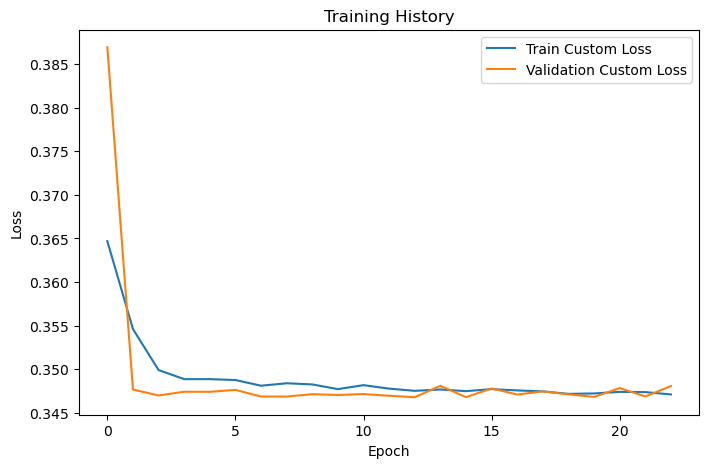

In [79]:
lstm_model = Sequential([
    layers.Input(shape=(20, len([c for c in df_cleaned.columns if c not in ('Dt','target_return')]))),
    layers.LSTM(64, return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(32, return_sequences=False),
    layers.Dropout(0.2),
    layers.Dense(1, activation='linear')
])

trained_lstm, lstm_history = train_sequence_model_expanding(
    model=lstm_model,
    df=df_cleaned,
    target_col='target_return',
    lookback=20,
    test_size=0.2,
    batch_size=32,
    epochs=50,
    patience=10,
    alpha=0.5,
    shuffle=False
)

In [80]:
return_predictions(trained_lstm, df_cleaned, lookback=20, target_col='target_return')[:50]

133/133 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step


array([ 0.00261872,  0.00937514,  0.0528945 ,  0.03221921,  0.0307986 ,
        0.027776  ,  0.02461816,  0.02452761,  0.0243119 ,  0.02192139,
        0.02452718,  0.05951644,  0.02971368,  0.02016788,  0.01544226,
        0.00225984,  0.04314745,  0.05018325,  0.05020652,  0.04890949,
        0.00654144, -0.02089032, -0.00940188,  0.02109399,  0.02491145,
        0.00618455,  0.00779076,  0.00124673, -0.00261285, -0.04587214,
       -0.05536465, -0.0537642 , -0.01353969, -0.00568023, -0.00408277,
       -0.0121665 , -0.04129027, -0.00650882, -0.02936647, -0.03226756,
       -0.02932236, -0.01675999, -0.01760099, -0.01635656, -0.04859757,
       -0.02522417, -0.01174944, -0.04736708, -0.05745687, -0.05663505],
      dtype=float32)

<font size=4, font color=blue>​ The following function does error analysis for convolutional models.

In [81]:
def plot_price_errors(model, df, lookback=90, price_col='Adj Close'):
   
    feature_cols = [c for c in df.columns if c not in ('Dt', 'target_return')]
    X_raw = df[feature_cols].values
    X_scaled = _expanding_scale(X_raw)[1:]

    
    X_seq = np.array([
        X_scaled[i - lookback + 1 : i + 1]
        for i in range(lookback - 1, len(X_scaled) - 1)
    ])

    
    y_pred = model.predict(X_seq).flatten()

    actual_prices = df[price_col][1:].values
    actual_aligned = actual_prices[lookback:]  

    pred_prices = actual_prices[lookback-1: -1] * (1 + y_pred)

    percent_errors = (pred_prices - actual_aligned)/actual_aligned*100

    dates = pd.to_datetime(df['Dt'][1:].iloc[lookback:].values)

    plt.figure(figsize=(10, 5))
    plt.plot(dates, percent_errors, label='Percent Error')
    plt.axhline(0, color='black', linewidth=0.8)
    plt.xlabel('Date')
    plt.ylabel('Price Error %')
    plt.title('Daily Prediction Percentage Error')
    plt.legend()
    plt.show()

133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


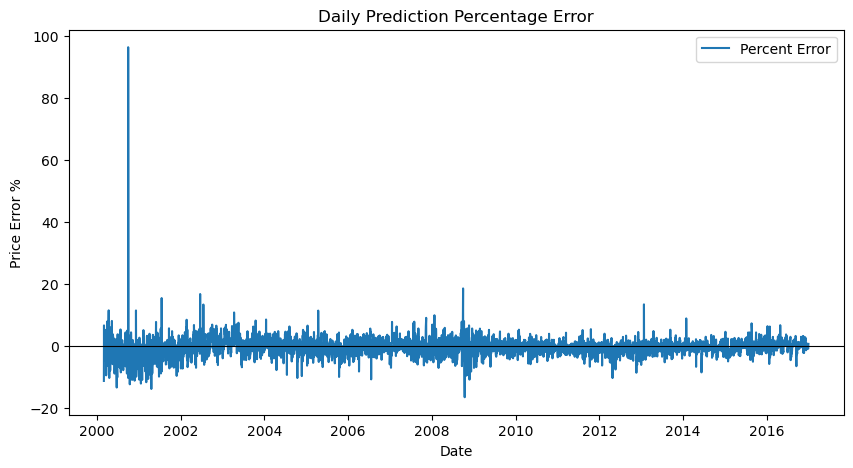

In [82]:
plot_price_errors(trained_lstm, df_cleaned, lookback=20)

<font size=4, font color=blue> A class of more advanced new features engineered from the original features (open, close, high, low, volume, adjusted close) are called technical indicators. Some well-known representatives are MACD and RSI, which are used by many traders and technical analysts. Technical features are also 'convolutional' in nature, serving as a way to gauge market sentiment and momentum of the stock based on recent days' original feature values. Their values can often suggest whether a stock is over-bought or over-sold, giving indications for possible stock price correctional movements.

In [83]:
o = df['Open'].values
h = df['High'].values
l = df['Low'].values
c = df['Adj Close'].values
v = df['Volume'].values
c1 = df['Close'].values


df['SMA_20']    = talib.SMA(c, timeperiod=20)
df['EMA_20']    = talib.EMA(c, timeperiod=20)
df['RSI_14']    = talib.RSI(c, timeperiod=14)
macd, macdsig, macdhist = talib.MACD(c, fastperiod=12, slowperiod=26, signalperiod=9)
df['MACD']      = macd
df['ATR_14']    = talib.ATR(h, l, c1, timeperiod=14)
slowk, slowd   = talib.STOCH(h, l, c1,
                              fastk_period=14, slowk_period=3, slowk_matype=0,
                              slowd_period=3, slowd_matype=0)
df['STOCH_K']   = slowk
df['STOCH_D']   = slowd
upper, middle, lower = talib.BBANDS(c, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
df['BB_UP']     = upper
df['BB_MID']    = middle
df['BB_LOW']    = lower
df['CCI_14']    = talib.CCI(h, l, c1, timeperiod=14)
df['ADX_14']    = talib.ADX(h, l, c1, timeperiod=14)
df['OBV']       = talib.OBV(c, v)
df['MOM_10']    = talib.MOM(c, timeperiod=10)
df['ROC_10']    = talib.ROC(c, timeperiod=10)
df['MFI_14']    = talib.MFI(h, l, c1, v, timeperiod=14)
df['PPO']       = talib.PPO(c, fastperiod=12, slowperiod=26, matype=0)
df['ULTOSC']    = talib.ULTOSC(h, l, c1,
                                timeperiod1=7, timeperiod2=14, timeperiod3=28)
df['WILLR_14']  = talib.WILLR(h, l, c1, timeperiod=14)
df['SAR']       = talib.SAR(h, l, acceleration=0.02, maximum=0.2)
df['ADXR_14']   = talib.ADXR(h, l, c1, timeperiod=14)


indicators = [
    'SMA_20','EMA_20','RSI_14','MACD','ATR_14','STOCH_K','STOCH_D',
    'BB_UP','BB_MID','BB_LOW','CCI_14','ADX_14','OBV','MOM_10',
    'ROC_10','MFI_14','PPO','ULTOSC','WILLR_14','SAR','ADXR_14'
]


scores_df = compute_ic_ir(df, indicators)

scores_df

,Pearson r,Spearman ρ,IR (Pearson),IR (Spearman)
feature,,,,
SMA_20,-0.0163,-0.0035,-1.2865,-1.3541
EMA_20,-0.0163,-0.0038,-1.3443,-1.3998
RSI_14,0.0068,0.0134,-0.5367,-0.2695
MACD,0.0033,0.0139,-0.5931,-0.3345
ATR_14,-0.0231,-0.0076,-0.7569,-0.7861
STOCH_K,0.0081,0.0124,-0.2912,-0.1114
STOCH_D,0.0116,0.0126,-0.2481,-0.1195
BB_UP,-0.0165,-0.0043,-1.3245,-1.3526
BB_MID,-0.0163,-0.0035,-1.2865,-1.3541


<font size=4, font color=blue> Again, conduct feature selection through correlation and information ratio. Descriptions of technical indicators used in the final model are given in a later sub-section.

In [84]:
mask = (
    (scores_df['Pearson r'].abs() > 0.01) & 
    (scores_df['IR (Pearson)'].abs() > 0.25)
) | (
    (scores_df['Spearman ρ'].abs() > 0.01) & 
    (scores_df['IR (Spearman)'].abs() > 0.25)
)

selected_features = scores_df[mask]

chosen_technical = selected_features.index.to_list()
chosen_technical

['SMA_20',
 'EMA_20',
 'RSI_14',
 'MACD',
 'ATR_14',
 'BB_UP',
 'BB_MID',
 'BB_LOW',
 'ROC_10',
 'PPO']

<font size=4 fint color='blue'> Drop technical indicators that didn't pass the test.

In [85]:
technical_drop = [f for f in indicators if f not in chosen_technical]
df_cleaned = df.copy()
df_cleaned = df_cleaned.drop(columns=technical_drop)
df_cleaned.drop(columns=['Div','Factor'],inplace=True)
df_cleaned.head()

,Dt,Adj Close,Close,High,Low,Open,Volume,return,target_return,oc_return,...,SMA_20,EMA_20,RSI_14,MACD,ATR_14,BB_UP,BB_MID,BB_LOW,ROC_10,PPO
0,2000-01-03,3.4785,111.938,112.500,101.688,104.8750,133949200.0,NaN,-0.084318,0.067347,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01-04,3.1852,102.500,110.625,101.188,108.2500,128094400.0,-0.084318,0.014630,-0.053118,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-01-05,3.2318,104.000,110.563,103.000,103.7500,194580400.0,0.014630,-0.086546,0.002410,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-01-06,2.9521,95.000,107.000,95.000,106.1183,191993200.0,-0.086546,0.047390,-0.104773,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-01-07,3.0920,99.500,101.000,95.500,96.5000,115183600.0,0.047390,-0.017594,0.031088,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
df_cleaned.dropna(inplace=True)

In [87]:
df = df.drop(columns=technical_drop)

<font size=4, font color=blue> Regime change: from the plot of Apple historical stock prices, we can notice that the stock price movement patterns before 2008-2009 and after are significantly different. One single model is unlikely to master all patterns in different regimes well. In financial settings, people usually train separate models for different regimes and specialized models to identify the time at which a change of regime happens. In this project, that is impractical, so we train our LSTM/Convolution models on the second regime (data after the 2008-2009 period) only, which is closer to the test set dates for grading.

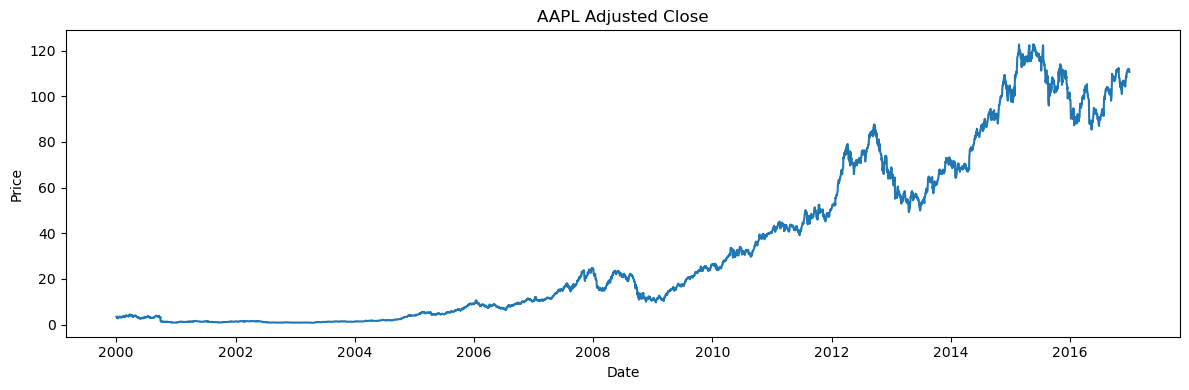

In [119]:
fig, axes = plt.subplots(1, 1, figsize=(12, 4), sharex=True)

axes.plot(df['Dt'], df['Adj Close'])
axes.set_title('AAPL Adjusted Close')
axes.set_xlabel('Date')
axes.set_ylabel('Price')

fig.tight_layout()
plt.show()

In [88]:
df_cleaned.iloc[2482]

Dt               2010-01-04 00:00:00
Adj Close                    26.6015
Close                         214.01
High                           214.5
Low                           212.38
Open                          213.43
Volume                   123432400.0
return                      0.015565
target_return               0.001729
oc_return                   0.002718
ch_gap                         -0.49
cl_gap                          1.63
co_ratio                    1.002718
oc_diff                         0.58
volume_zscore              -0.133809
vol_to_range         58222830.188679
overnight_gap               0.012803
SMA_20                      24.86831
EMA_20                     25.297403
RSI_14                     67.302503
MACD                        0.488057
ATR_14                      4.196666
BB_UP                      26.813219
BB_MID                      24.86831
BB_LOW                     22.923401
ROC_10                     11.545106
PPO                         2.131999
N

Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - loss: 0.5030 - mae: 0.1016 - val_loss: 0.4933 - val_mae: 0.0626
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.5036 - mae: 0.1048 - val_loss: 0.5344 - val_mae: 0.2077
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.4903 - mae: 0.0488 - val_loss: 0.4888 - val_mae: 0.0498
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.4886 - mae: 0.0460 - val_loss: 0.4879 - val_mae: 0.0469
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.4867 - mae: 0.0401 - val_loss: 0.4856 - val_mae: 0.0193
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.4853 - mae: 0.0388 - val_loss: 0.4867 - val_mae: 0.0376
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.4850 - mae: 0.0387 - val_loss: 0.4858 - val_mae: 0.0249
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.4854 - mae: 0.0357 - val_loss: 0.4860 - val_mae: 0.0285
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - l

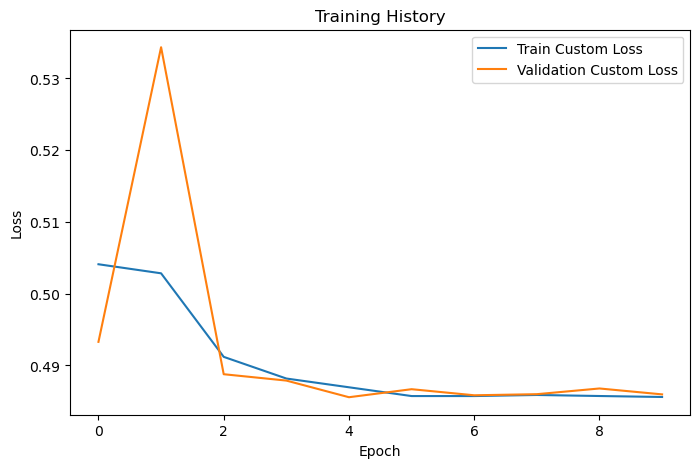

In [102]:
lstm_model3 = Sequential([
    layers.Input(shape=(20, len([c for c in df_cleaned.columns if c not in ('Dt','target_return')]))),
    layers.LSTM(64, return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(32, return_sequences=False),
    layers.Dropout(0.2),
    layers.Dense(1, activation='linear')
])

trained_lstm3, lstm_history3 = train_sequence_model_expanding(
    model=lstm_model3,
    df=df_cleaned.iloc[2482:],
    target_col='target_return',
    lookback=20,
    test_size=0.2,
    batch_size=32,
    epochs=100,
    patience=5,
    alpha=0.7,
    shuffle=False
)

<font size=4 font color='blue'> Check first 50 predicted returns

In [103]:
return_predictions(trained_lstm3, df_cleaned.iloc[2482:], lookback=20, target_col='target_return')[:50]

55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step


array([-0.02139144, -0.01600719, -0.02278852, -0.02079291, -0.00871605,
       -0.00794113, -0.00259524,  0.01643414,  0.01889145, -0.08008081,
       -0.06073033, -0.05084906, -0.05015939, -0.02896567, -0.02445384,
       -0.02932707, -0.02922384, -0.031735  , -0.03123341, -0.02105074,
       -0.02734632, -0.02897485, -0.00632685,  0.00331751, -0.03146297,
        0.00630926,  0.01496051,  0.02014325,  0.02444821,  0.01321796,
        0.00768244,  0.00464975,  0.00950021,  0.0068273 , -0.0084283 ,
       -0.02495646, -0.00440059,  0.01011466,  0.0366868 ,  0.02900348,
        0.01353437,  0.03406752,  0.02235063,  0.04064802,  0.00711638,
        0.02602465,  0.01018367, -0.01463573, -0.01797437,  0.02226039],
      dtype=float32)

<font size=4, font color=blue> Training errors for the first half is a bit large and stock prices are underestimated, due to time constraints I won't finetune and re-run all models, but I will make sure the final model is finetuned and re-run until results seem optimal.

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


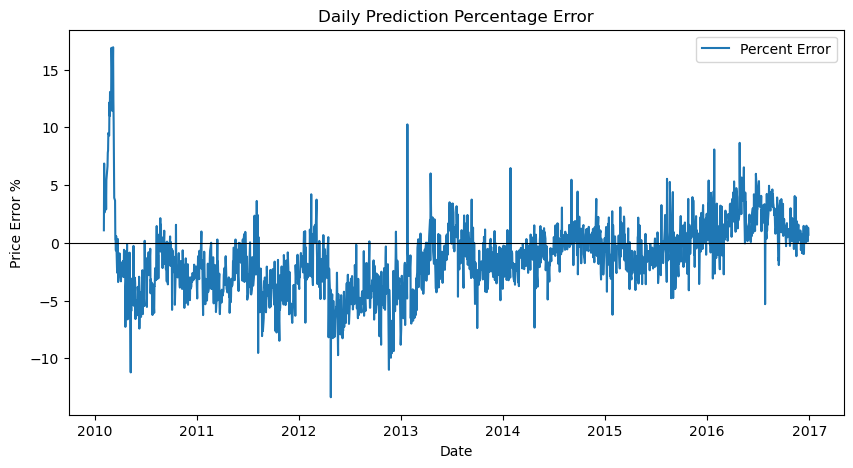

In [104]:
plot_price_errors(trained_lstm3, df_cleaned.iloc[2482:], lookback=20)

<font size=4, font color=blue> Unlike LSTM which 'remembers' past data and updates its cell state and hidden state according to new input data, 1D Convolutional layer is another popular convolution choice in financial analysis. It simply computes the dot product between the kernel and the feature values across the time dimension in each stride. Here we try combining LSTM and 1D Convolutional layers in order to learn different kinds of patterns.

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 22s 97ms/step - loss: 0.4992 - mae: 0.2066 - val_loss: 0.4213 - val_mae: 0.0418
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.4324 - mae: 0.0870 - val_loss: 0.4277 - val_mae: 0.0798
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.4222 - mae: 0.0493 - val_loss: 0.4205 - val_mae: 0.0276
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.4235 - mae: 0.0487 - val_loss: 0.4196 - val_mae: 0.0227
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.4206 - mae: 0.0373 - val_loss: 0.4199 - val_mae: 0.0274
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.4202 - mae: 0.0383 - val_loss: 0.4190 - val_mae: 0.0151
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.4200 - mae: 0.0359 - val_loss: 0.4197 - val_mae: 0.0283
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.4199 - mae: 0.0356 - val_loss: 0.4196 - val_mae: 0.0256
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.41

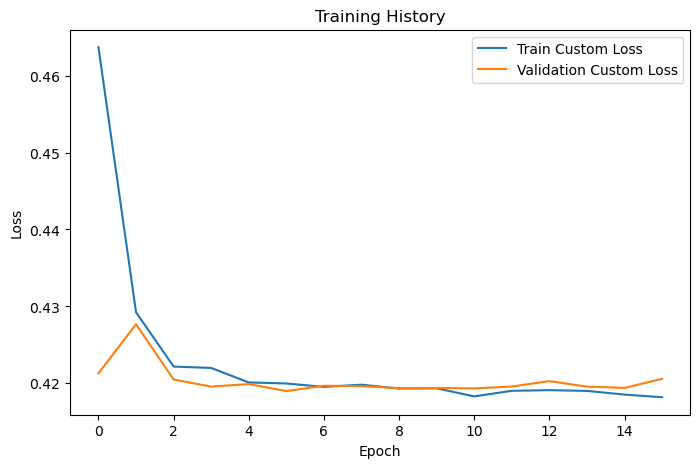

In [109]:
cnn_model = Sequential([
    layers.Input(shape=(20, len([c for c in df_cleaned.columns if c not in ('Dt','target_return')]))),   
    layers.Conv1D(32, kernel_size=3, activation='relu',kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.2),
    layers.LSTM(64, return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(64, return_sequences=False),
    layers.Dropout(0.2),
    layers.Dense(1, activation='linear')       
])
trained_cnn, cnn_history = train_sequence_model_expanding(
    model=cnn_model,
    df=df_cleaned.iloc[2482:],
    target_col='target_return',
    lookback=20,
    test_size=0.2,
    batch_size=32,
    epochs=50,
    patience=10,
    alpha=0.6,
    shuffle=False
)

In [110]:
return_predictions(trained_cnn, df_cleaned.iloc[2482:], lookback=20, target_col='target_return')[:50]

55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step


array([-0.01907311, -0.03114045, -0.02600966, -0.01906408, -0.01461588,
       -0.00367364, -0.01314048, -0.03070939, -0.03004749,  0.01126575,
        0.0023248 ,  0.02765575,  0.02995844,  0.04530571,  0.05458264,
        0.05638508,  0.04109728,  0.06423169,  0.04522059,  0.04045082,
        0.0100395 ,  0.03542997,  0.05462133,  0.17656931,  0.11613776,
        0.11944379,  0.08731392,  0.06845179,  0.04124083,  0.06790235,
        0.08810075,  0.06162769,  0.03989306,  0.10976758,  0.08677841,
        0.04313631,  0.02993906,  0.01464705, -0.00079847, -0.0183365 ,
       -0.01682962,  0.01043324,  0.04804359,  0.09204131,  0.08254725,
        0.02458836,  0.02600417,  0.06297628,  0.11542428,  0.12578352],
      dtype=float32)

<font size=4, font color=blue> Training errors for the first half is a bit large and stock prices are underestimated, due to time constraints I won't finetune and re-run all models, but I will make sure the final model is finetuned and re-run until results seem optimal.

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


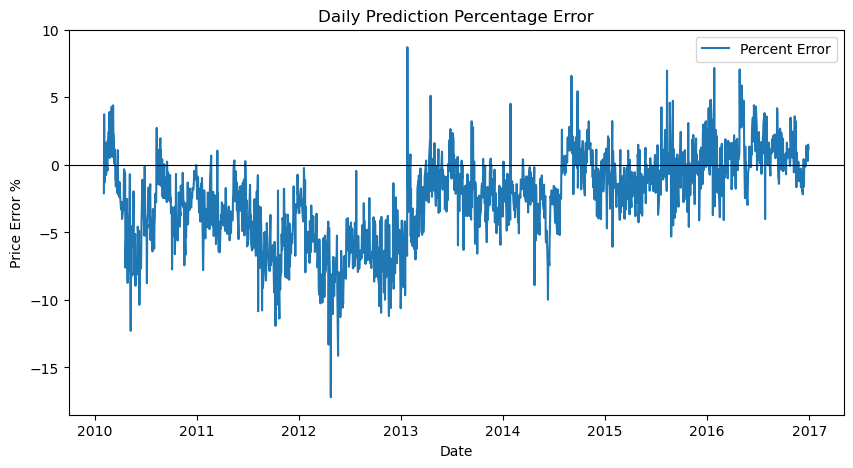

In [111]:
plot_price_errors(trained_cnn, df_cleaned.iloc[2482:], lookback=20)

<font size=4, font color=blue> Some other companies' returns may be correlated with Apple's returns, so we may use their returns as features to predict Apple's return.

In [112]:
def append_other_returns(df, 
                         directory="./Data/train", 
                         price_col="Adj Close", 
                         date_col="Dt"):
    
    df_out = df.copy()
    df_out[date_col] = pd.to_datetime(df_out[date_col])
    
    tickers = [
      "ACN","ADBE","CRM","CSCO","FB","GOOG","IBM","INTC","MA","MSFT",
      "NVDA","SPY","V","XLB","XLE","XLF","XLI","XLK","XLRE","XLU",
      "XLV","XLY"
    ]
    
    for ticker in tickers:
        file_path = os.path.join(directory, f"{ticker}.csv")
        if not os.path.isfile(file_path):
            print(f"⚠️  {ticker}.csv not found, skipping")
            continue
        
        
        tmp = pd.read_csv(
            file_path,
            parse_dates=[date_col],
            usecols=[date_col, price_col]
        )
        tmp[date_col] = pd.to_datetime(tmp[date_col])
        
    
        ret_col = ticker
        tmp[ret_col] = tmp[price_col].pct_change()
        
        
        tmp = tmp[[date_col, ret_col]]
        

        df_out = df_out.merge(tmp, on=date_col, how="left")
    
    return df_out


df = append_other_returns(df, directory="./Data/train", price_col="Adj Close", date_col="Dt")
df.head()


,Dt,Adj Close,Close,Div,Factor,High,Low,Open,Volume,return,...,V,XLB,XLE,XLF,XLI,XLK,XLRE,XLU,XLV,XLY
0,2000-01-03,3.4785,111.938,0.0,1.0,112.500,101.688,104.8750,133949200.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01-04,3.1852,102.500,0.0,1.0,110.625,101.188,108.2500,128094400.0,-0.084318,...,NaN,-0.009628,-0.018826,-0.043724,-0.027626,-0.050733,NaN,-0.030159,-0.022693,-0.030081
2,2000-01-05,3.2318,104.000,0.0,1.0,110.563,103.000,103.7500,194580400.0,0.014630,...,NaN,0.041312,0.026380,-0.007850,-0.004454,-0.014847,NaN,0.025230,-0.008971,-0.012301
3,2000-01-06,2.9521,95.000,0.0,1.0,107.000,95.000,106.1183,191993200.0,-0.086546,...,NaN,0.025672,0.038550,0.043918,0.013427,-0.033150,NaN,-0.001714,0.003194,0.011370
4,2000-01-07,3.0920,99.500,0.0,1.0,101.000,95.500,96.5000,115183600.0,0.047390,...,NaN,-0.000568,0.010688,0.016543,0.038102,0.017455,NaN,0.008598,0.012207,0.047108


<font size=4, font color=blue> Like I did previously with simple features and technical indicator features, correlation and information ratio are used again to filter out the weak features. Chosen companies' names will be given in the sub-section containing the final model.

In [113]:
tickers = [
      "ACN","ADBE","CRM","CSCO","FB","GOOG","IBM","INTC","MA","MSFT",
      "NVDA","SPY","V","XLB","XLE","XLF","XLI","XLK","XLRE","XLU",
      "XLV","XLY"
    ]

ticker_scores = compute_ic_ir(df, tickers)
ticker_scores

,Pearson r,Spearman ρ,IR (Pearson),IR (Spearman)
feature,,,,
ACN,-0.0477,-0.0180,-0.2485,-0.0822
ADBE,-0.0252,-0.0057,-0.0124,0.0134
CRM,-0.0317,-0.0121,-0.2517,-0.1630
CSCO,-0.0207,-0.0205,-0.1639,-0.2358
FB,-0.0086,-0.0309,-0.2466,-0.9677
GOOG,-0.0071,-0.0090,-0.0819,-0.1876
IBM,0.0115,-0.0082,0.0661,-0.0966
INTC,-0.0031,-0.0065,0.0378,-0.0664
MA,-0.0481,-0.0131,-0.1942,-0.0430


In [114]:
mask = (
    (ticker_scores['Pearson r'].abs() > 0.02) & 
    (ticker_scores['IR (Pearson)'].abs() > 0.3)
) | (
    (ticker_scores['Spearman ρ'].abs() > 0.02) & 
    (ticker_scores['IR (Spearman)'].abs() > 0.3)
)

selected_stocks = ticker_scores[mask]

chosen_stocks = selected_stocks.index.to_list()

chosen_stocks.remove('FB')
chosen_stocks.remove('XLRE')
chosen_stocks

['V', 'XLF', 'XLI', 'XLU', 'XLV']

In [115]:
df_cleaned = df.copy()

to_drop = [f for f in tickers if f not in chosen_stocks]

df_cleaned = df_cleaned.drop(columns=to_drop)
df = df.drop(columns=to_drop)
df_cleaned.dropna(inplace=True)
df_cleaned.drop(columns=['Div','Factor'],inplace=True)
df_cleaned.head()

,Dt,Adj Close,Close,High,Low,Open,Volume,return,target_return,oc_return,...,BB_UP,BB_MID,BB_LOW,ROC_10,PPO,V,XLF,XLI,XLU,XLV
2064,2008-03-20,16.5655,133.27,133.292,129.18,131.12,227196900.0,0.027764,0.046971,0.016397,...,16.589282,15.539815,14.490348,10.204503,1.204025,0.138941,0.072014,0.010511,-0.002905,0.001256
2065,2008-03-24,17.3436,139.53,140.850,133.64,134.01,266730100.0,0.046971,0.010390,0.041191,...,16.927246,15.664550,14.401854,14.134920,1.889242,-0.071795,0.012919,0.022658,0.003205,0.013185
2066,2008-03-25,17.5238,140.98,143.100,137.33,139.96,263097800.0,0.010390,0.028943,0.007288,...,17.243661,15.796555,14.349449,17.787263,2.795621,0.058927,-0.002999,0.006139,-0.002929,0.001905
2067,2008-03-26,18.0310,145.06,145.740,140.64,140.87,295521100.0,0.028943,-0.033160,0.029744,...,17.629243,15.957585,14.285927,13.906858,3.658550,0.011230,-0.036121,-0.007958,0.003738,-0.009821
2068,2008-03-27,17.4331,140.25,145.310,139.99,144.95,249957400.0,-0.033160,0.019681,-0.032425,...,17.823712,16.065045,14.306378,11.283393,4.438106,-0.016422,-0.015612,-0.010967,0.010108,0.005120


<font size=4, font color=blue> Following the regime change discussion above, the final model is trained on data from 2011 to the end of the training set. Data before 2011 are discarded.

In [116]:
df_cleaned.iloc[703]

Dt               2011-01-03 00:00:00
Adj Close                    40.9656
Close                         329.57
High                          330.26
Low                          324.837
Open                          325.64
Volume                   111284600.0
return                      0.021731
target_return               0.005219
oc_return                   0.012069
ch_gap                         -0.69
cl_gap                         4.733
co_ratio                    1.012069
oc_diff                         3.93
volume_zscore               1.410127
vol_to_range         20520855.614973
overnight_gap               0.009549
SMA_20                     40.088475
EMA_20                     40.044451
RSI_14                     66.748578
MACD                        0.411557
ATR_14                      3.868911
BB_UP                      40.738297
BB_MID                     40.088475
BB_LOW                     39.438653
ROC_10                      2.794597
PPO                         0.950043
V

<font size=4, font color=blue> This is the final model, called trained_cnn4, but it's actually a combination of LSTM and 1D Convolutional layers and a dense head in the end. It is fitted on the whole training set without a validation set.

Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.4299 - mae: 0.0609
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.4234 - mae: 0.0209
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.4231 - mae: 0.0159
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.4226 - mae: 0.0153
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.4221 - mae: 0.0158
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.4216 - mae: 0.0168
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.4219 - mae: 0.0223
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.4213 - mae: 0.0163
Epoch 9/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.4210 - mae: 0.0164
Epoch 10/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.4211 - mae: 0.0237
Epoch 11/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.4205 - mae: 0.0177
Epoch 12/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.4199 - mae: 0.0148
Epoch 13/50
47/47 ━━━━━━━━━━━━━━━━━━

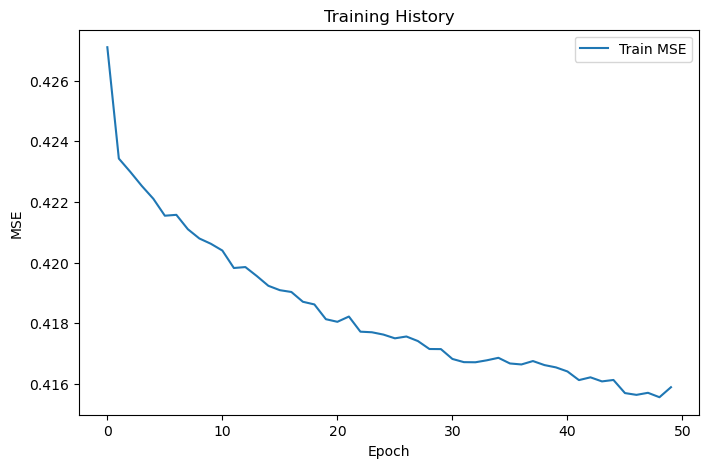

In [48]:
cnn_model4 = Sequential([
    layers.Input(shape=(20, len([c for c in df_cleaned.columns if c not in ('Dt','target_return')]))),  
    layers.Conv1D(32, kernel_size=3, activation='relu',kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.2),
    layers.LSTM(64, return_sequences=True),
    layers.Dropout(0.2),
    layers.Conv1D(32, kernel_size=3, activation='relu',kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.2),
    layers.LSTM(64, return_sequences=False),
    layers.Dropout(0.2),
    layers.Dense(1, activation='linear')       
])
trained_cnn4, cnn_history4 = train_sequence_model_expanding(
    model=cnn_model4,
    df=df_cleaned.iloc[703:],
    target_col='target_return',
    lookback=20,
    test_size=None,
    batch_size=32,
    epochs=50,
    patience=5,
    alpha=0.6,
    shuffle=False
)

<font size=4, font color=blue> Training errors of the final model are relatively stable over the whole training set.

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


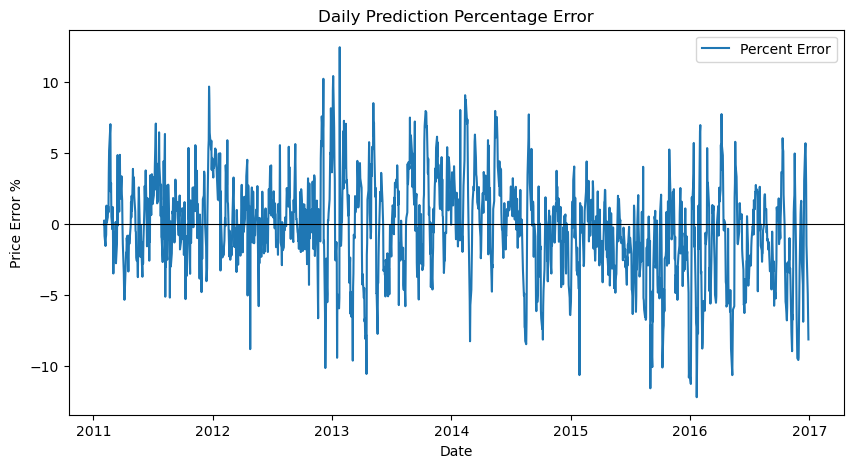

In [122]:
plot_price_errors(trained_cnn4, df_cleaned.iloc[703:], lookback=20)

<font size=4, font color=blue> Some of the predicted returns are printed below. It can be seen that the model actively tries to discern between stock rising and falling in its predictions, instead of predicting returns oscillating around a local average and resulting in overwhelmingly positive/negative predicted returns.

In [124]:
x=return_predictions(trained_cnn4, df_cleaned, lookback=20, target_col='target_return')
x[-100:]

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


array([-1.43002206e-03, -2.59772921e-03, -1.79072004e-03,  7.19736796e-04,
        4.05056216e-03,  5.37399948e-03,  8.61451402e-03,  9.49331746e-03,
        1.03230793e-02,  1.11733973e-02,  1.17760636e-02,  1.29401218e-02,
        1.48798283e-02,  1.55676417e-02,  1.54419858e-02,  1.59619991e-02,
        1.58762224e-02,  1.77075639e-02,  1.88196655e-02,  1.88831724e-02,
        2.05774568e-02,  2.03530304e-02,  1.97783671e-02,  1.94218848e-02,
        1.79974344e-02,  1.61349941e-02,  1.35701075e-02,  1.04600396e-02,
        7.32970424e-03,  4.81041009e-03,  2.65177898e-03,  1.17433770e-03,
       -6.12551812e-04, -1.74866850e-03, -2.27872189e-03, -1.22797908e-03,
       -1.96501380e-03, -2.31310306e-03, -1.18628284e-03, -6.62088394e-04,
       -2.83461390e-03, -3.89895262e-03, -3.88382329e-03, -2.37199618e-03,
        4.42833174e-04,  2.56910245e-03,  3.91142629e-03,  4.42518992e-03,
        5.54689206e-03,  5.50672412e-03,  4.01194952e-03,  1.56567991e-03,
        1.34176482e-03,  

<font size=4, font color=blue> Try saving and loading the final model.

In [24]:
from tensorflow.keras.models import load_model

modelName = "final_model"
model_path = os.path.join(".", modelName)

def saveModel(model, model_path): 
    
    model_save_file = model_path + '.keras'
      
    model.save(model_save_file)
    
    print(f"Model saved in {model_save_file:s}; submit with your assignment.")
    
    return model_save_file
   
def loadModel(model_save_file):
    model = tf.keras.models.load_model(model_save_file,compile=False)
  
    return model

In [50]:
my_model = trained_cnn4

model_save_file = saveModel(my_model, model_path)

Model saved in .\final_model.keras; submit with your assignment.


In [51]:
loaded = loadModel('./final_model.keras')
loaded.compile(
    optimizer="adam",
    loss=multitask_loss(alpha=0.6),
    metrics=["mae"]
)

<font size=4, font color=blue> Name of all features in the final df used to train the final model

In [49]:
df_cleaned.columns

Index(['Dt', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'return',
       'target_return', 'oc_return', 'ch_gap', 'cl_gap', 'co_ratio', 'oc_diff',
       'volume_zscore', 'vol_to_range', 'overnight_gap', 'SMA_20', 'EMA_20',
       'RSI_14', 'MACD', 'ATR_14', 'BB_UP', 'BB_MID', 'BB_LOW', 'ROC_10',
       'PPO', 'V', 'XLF', 'XLI', 'XLU', 'XLV'],
      dtype='object')

<font size=4, font color=red> Here, as promised, I give descriptions of all features that are used in the final model. Feature values of every 20 consecutive days (20 rows in the df) are bundled together to form a 2D array as a sample for training the final model cnn_4 and making predictions on the test set.

<font size=6, font color='blue'> Section 3: Testing (Not for grading!)

<font size=4, font color=blue> The sample directory contains stock data in 2017. Here we use it as the test set for the final model. extract_features_from_dir function collects all relevant data from stock csv files within the directory and computes all feature values and returns them in one df. The function is defined below in the grading section.

In [98]:
test_set = extract_features_from_dir('./Data/sample')
test_set

,Dt,Adj Close,Close,High,Low,Open,Volume,return,target_return,oc_return,...,BB_UP,BB_MID,BB_LOW,ROC_10,PPO,V,XLF,XLI,XLU,XLV
0,2017-01-03,110.9418,116.15,116.3300,114.760,115.80,28781865.0,NaN,-0.001120,0.003022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-04,110.8176,116.02,116.5100,115.750,115.85,21118116.0,-0.001120,0.005086,0.001467,...,NaN,NaN,NaN,NaN,NaN,0.008177,0.008081,0.005912,0.003717,0.007874
2,2017-01-05,111.3812,116.61,116.8642,115.810,115.92,22193587.0,0.005086,0.011148,0.005952,...,NaN,NaN,NaN,NaN,NaN,0.011728,-0.010128,-0.002859,0.001028,0.005115
3,2017-01-06,112.6229,117.91,118.1600,116.470,116.78,31751900.0,0.011148,0.009160,0.009676,...,NaN,NaN,NaN,NaN,NaN,0.013811,0.003411,0.005734,0.003082,0.002827
4,2017-01-09,113.6545,118.99,119.4300,117.940,117.95,33561948.0,0.009160,0.001008,0.008817,...,NaN,NaN,NaN,NaN,NaN,-0.005595,-0.006798,-0.007760,-0.013108,0.004228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,2017-12-22,169.8633,175.01,175.4240,174.500,174.68,16052615.0,0.000000,-0.025370,0.001889,...,171.500739,167.176675,162.852611,3.330026,0.462182,0.002491,-0.002843,0.000265,0.001528,-0.003246
247,2017-12-26,165.5539,170.57,171.4700,169.679,170.80,32968167.0,-0.025370,0.000176,-0.001347,...,171.302839,167.005855,162.708871,-1.216167,0.534546,0.002663,-0.002855,0.001061,-0.005911,0.000242
248,2017-12-27,165.5830,170.60,170.7800,169.710,170.10,21672062.0,0.000176,0.002814,0.002939,...,171.201265,166.885990,162.570715,-0.640622,0.583948,0.009116,0.001073,0.002385,0.004221,0.001689
249,2017-12-28,166.0489,171.08,171.8500,170.480,171.00,15997739.0,0.002814,-0.010814,0.000468,...,171.158293,166.963640,162.768987,-0.690773,0.482358,0.002894,0.003928,0.001982,0.005537,0.001444


<font size=4, font color='blue'> Standardize the testing set

In [95]:
_,scaled_test = expanding_standardize(df_cleaned.iloc[703:],test_set)

<font size=4, font color='blue'> Compute MSE between true returns and predicted returns

In [30]:
def evaluate_sequence_model(model, df, lookback=30, target_col='target_return'):
   
    feature_cols = [c for c in df.columns if c not in ('Dt', target_col)]
    
    data    = df[feature_cols].values
    targets = df[target_col].values
    
    X_seq, y_true = [], []
    for i in range(lookback - 1, len(df)):
        X_seq.append(data[i - lookback + 1 : i + 1])
        y_true.append(targets[i])
    X_seq  = np.array(X_seq)      
    y_true = np.array(y_true)   
    
    y_pred = model.predict(X_seq).flatten()

    mse = mean_squared_error(y_true, y_pred)
    return mse

In [56]:
mse = evaluate_sequence_model(loaded, scaled_test, lookback=20)
print(f"Test MSE: {mse:.6f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Test MSE: 0.000369


<font size=4, font color=blue> Return predictions are shown for the first 100 dates. There is a healthy blend of positive and negative returns.

In [84]:
x=return_predictions(loaded, scaled_test, lookback=20, target_col='target_return')
x[:100]

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


array([ 0.01337854,  0.00723036,  0.00037768, -0.00675678, -0.01136178,
       -0.01323203, -0.01188676, -0.00874607, -0.00429271,  0.00162081,
        0.00661698,  0.00966101,  0.01161166,  0.01300245,  0.0131649 ,
        0.0117725 ,  0.00971909,  0.00688534,  0.00395441, -0.00067638,
       -0.00308803, -0.00368638, -0.00176474,  0.00146306,  0.00527435,
        0.00861534,  0.0122388 ,  0.01515579,  0.0163164 ,  0.01533468,
        0.01045956,  0.00359259, -0.00438342, -0.01138178, -0.01698645,
       -0.01972408, -0.02002116, -0.01763549, -0.01374105, -0.00792584,
       -0.00087848,  0.00675944,  0.0122278 ,  0.01435499,  0.01401912,
        0.01337407,  0.01341179,  0.01390216,  0.01436257,  0.01472897,
        0.01513362,  0.01554327,  0.01510959,  0.0134847 ,  0.01171   ,
        0.01003288,  0.00833204,  0.00702061,  0.00423524, -0.00227338,
       -0.00689556, -0.00948565, -0.01017525, -0.01002105, -0.00911801,
       -0.0082862 , -0.0074795 , -0.00660531, -0.00592778, -0.00

<font size=6, font color='red'> Section 4: Grading Section (contains MyModel())

<font size=5, font color='red'> Please run the following cells for grading, and make sure Train data under Data directory is still available, as we are promised that all historical data up to T-1 are available (please don't remove Train when adding Holdout to Data directory)

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import callbacks
from tensorflow.keras import Sequential, layers, regularizers
import numpy as np
from scipy.stats import pearsonr, spearmanr
from tensorflow.keras.callbacks import EarlyStopping
import talib
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.losses import Loss
from tensorflow.keras.utils import register_keras_serializable
import tensorflow.keras.backend as K

In [2]:
def loadModel(model_save_file):
    model = tf.keras.models.load_model(model_save_file,compile=False)
    return model

In [3]:
def extract_features_from_dir(path):

    df = pd.read_csv(os.path.join(path, "AAPL.csv"), parse_dates=["Dt"])
    df = df.reset_index(drop=True)

    df["return"]        = df["Adj Close"].pct_change()
    df["target_return"] = df["return"].shift(-1)

    df['oc_return'] = (df['Close'] - df['Open']) / df['Open']
    df["ch_gap"]        = df['Close'] - df['High']
    df["cl_gap"]        = df['Close'] - df['Low']
    df["co_ratio"]      = df["Close"] / df["Open"]
    df['oc_diff']       = df['Close'] - df['Open']
    df["overnight_gap"] = df["Open"]  / df["Close"].shift(1) - 1
    df["vol_to_range"]  = df["Volume"]/(df["High"] - df["Low"])
    df["volume_zscore"] = (
        df["Volume"] - df["Volume"].rolling(20).mean()
    ) / df["Volume"].rolling(20).std()

    o, h, l, c, v, c1 = (
        df["Open"].values, df["High"].values, df["Low"].values,
        df["Adj Close"].values, df["Volume"].values, df['Close'].values
    )
    df["SMA_20"] = talib.SMA(c, timeperiod=20)
    df["EMA_20"] = talib.EMA(c, timeperiod=20)
    df["RSI_14"] = talib.RSI(c, timeperiod=14)
    macd, _, _  = talib.MACD(c, fastperiod=12, slowperiod=26, signalperiod=9)
    df["MACD"]   = macd
    df["ATR_14"] = talib.ATR(h, l, c1, timeperiod=14)
    up, mid, lo  = talib.BBANDS(c, timeperiod=20, nbdevup=2, nbdevdn=2)
    df["BB_UP"], df["BB_MID"], df["BB_LOW"] = up, mid, lo
    df["ROC_10"] = talib.ROC(c, timeperiod=10)
    df["PPO"]    = talib.PPO(c, fastperiod=12, slowperiod=26)

    tickers = ["V","XLF","XLI","XLU","XLV"]
    for t in tickers:
        tmp = pd.read_csv(os.path.join(path, f"{t}.csv"), parse_dates=["Dt"])
        tmp = tmp.reset_index(drop=True)
        df = df.merge(
            tmp[["Dt"]].assign(**{t: tmp["Adj Close"].pct_change()}),
            on="Dt", how="left"
        )

    df = df.drop(columns=[c for c in ("Div","Factor") if c in df.columns])

    cols = [
      "Dt","Adj Close","Close","High","Low","Open","Volume",
      "return","target_return","oc_return","ch_gap","cl_gap",
      "co_ratio","oc_diff","volume_zscore","vol_to_range",
      "overnight_gap","SMA_20","EMA_20","RSI_14","MACD",
      "ATR_14","BB_UP","BB_MID","BB_LOW","ROC_10","PPO",
      "V","XLF","XLI","XLU","XLV"
    ]
    return df[cols].copy()


def expanding_standardize(df_train, df_test=None):
    unscaled = {"Dt","target_return"}
    cols = [c for c in df_train.columns if c not in unscaled]

    if df_test is None:
        df_all = df_train.reset_index(drop=True).copy()
        X = df_all[cols].astype(float).values
        Xs = np.zeros_like(X)
        scaler = StandardScaler()
        for i in range(len(X)):
            scaler.fit(X[:i+1])
            Xs[i] = scaler.transform(X[i:i+1])[0]
        df_all[cols] = Xs
        return df_all
    else:
        df_all = pd.concat([df_train, df_test], ignore_index=True).copy()
        X = df_all[cols].astype(float).values
        Xs = np.zeros_like(X)
        scaler = StandardScaler()
        for i in range(len(X)):
            scaler.fit(X[:i+1])
            Xs[i] = scaler.transform(X[i:i+1])[0]
        df_all[cols] = Xs
        n = len(df_train)
        return (
            df_all.iloc[:n].reset_index(drop=True),
            df_all.iloc[n:].reset_index(drop=True)
        )
    
def return_predictions(model, df, lookback=20, target_col='target_return'):
   
    feature_cols = [c for c in df.columns if c not in ('Dt', target_col)]
    
    data    = df[feature_cols].values 
    X_seq   = []
    
    for i in range(lookback - 1, len(df)):
        X_seq.append(data[i - lookback + 1 : i + 1])
    X_seq  = np.array(X_seq)        
    
    y_pred = model.predict(X_seq).flatten()

    return y_pred

In [4]:
def predict_price_last_n(
    model,
    df_test,
    df_cleaned,
    lookback = 20,
    n_days = 200,
    price_col = "Adj Close",
    date_col = "Dt",
    target_col = "target_return"
):
    
    _, df_test_std = expanding_standardize(df_cleaned, df_test)
    
    y_pred = return_predictions(model, df_test_std, lookback=lookback, target_col=target_col)
    
    total_preds = len(y_pred)
    idxs = np.arange(lookback - 1, lookback - 1 + total_preds)
    
    raw_prices = df_test[price_col].values
    prev_prices = raw_prices[idxs - 1]  
    pred_prices = prev_prices * (1.0 + y_pred)
    
    dates = pd.to_datetime(df_test[date_col].values[idxs])

    dates_tail = dates[-n_days:]
    pred_prices_tail = pred_prices[-n_days:]
    
    return pred_prices_tail, dates_tail 


In [5]:
modelName = "final_model"
model_path = os.path.join(".", modelName)
model_save_file = model_path + '.keras' 

def multitask_loss(alpha=1.0):
    def loss(y_true, y_pred):
        
        mse = K.mean(K.square(y_pred - y_true), axis=-1)
  
        y_true_sign = K.cast(K.greater(y_true, 0), K.floatx())
        
        y_pred_prob = K.sigmoid(y_pred)
        
        bce = K.mean(
            K.binary_crossentropy(y_true_sign, y_pred_prob),
            axis=-1
        )
        
        return mse + alpha * bce

    return loss


def MyModel(test_dir, model_save_file):
    
    model = loadModel(model_save_file)
    model.compile(
    optimizer="adam",
    loss=multitask_loss(alpha=0.6),
    metrics=["mae"]
)
    
    df_test = extract_features_from_dir(test_dir)
    df_cleaned = extract_features_from_dir('./Data/Train').dropna()
    predictions,ids = predict_price_last_n(model,df_test,df_cleaned)
    
    return predictions, ids

In [ ]:
holdout_dir = os.path.join(".", "Data", "holdout")
predicts = MyModel(holdout_dir, model_save_file)
predicts

<font size=4, font color='red'> Since I experimented with the innovative method of using custom loss function to train my ML models, the MSE in the holdout dataset might turn out to be bigger than when using ordinary MSE loss to train models, but my model should have a higher chance of predicting the correct direction of stock price movements.

In [ ]:
print("Done")